# Importing Libraries

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from tqdm import tqdm

# Utility functions

In [85]:
# True function
def f(x):
    return 2*x + 3

def plot_true_function(label='y = 2x + 3'):
    x = np.linspace(-10, 10, 100)
    plt.plot(x, f(x), label=label)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Function')
    plt.legend()

    plt.grid(True)
    plt.show()


def generate_data(num_datapoints=100, num_samples=200, noise_std_dev=10):
    np.random.seed(42)
    x_values = np.random.choice(range(-num_datapoints, num_datapoints+1, 1), 
                                 size=num_datapoints,
                                 replace=False)

    # Add random noise to y values for each sample

    samples = []
    for i in tqdm(range(num_samples), total=num_samples):
        one_sample_set = []
        for x in x_values:
            y_true = f(x)

            # Add random noise to y
            noise = np.random.normal(0, noise_std_dev)
            y_with_noise = y_true + noise

            # Store the sample dataset as a tuple (x, y_with_noise)
            one_sample_set.append((x, y_with_noise))

        samples.append(np.array(one_sample_set))
    return samples
   

def plot_true_function_with_data(data, figsize=(10,6),zoom_in=None):
    # Plot the true function
    x = data[:, 0]
    y_with_noise = data[:, 1]
    true_function_values = f(x)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, true_function_values, label='True Function: $y = 2x + 3$', color='blue', linewidth=1)
    ax.scatter(x, y_with_noise, color='red', label='Sample Data with Noise', s=5)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    if zoom_in:
        inset_axes_obj = inset_axes(ax, width="30%", height="30%", loc="lower right")
        inset_axes_obj.plot(x, true_function_values, color='blue', linewidth=1)
        inset_axes_obj.scatter(x, y_with_noise, color='red', s=4)
        inset_axes_obj.set_xlim(zoom_in)
        inset_axes_obj.set_title(f'Zoomed In:{zoom_in}')

    if zoom_in:
        ax.set_title(f'True Function with Sample Data; zoomed in={zoom_in}')
    else:
        ax.set_title('True Function with Sample Data')

    ax.grid(True)
    plt.show()


# Creating Data

Lets first assume the true function, $$y=f(x) + \epsilon = 2x + 3 + \epsilon$$ where $\epsilon$ is the irreducible error

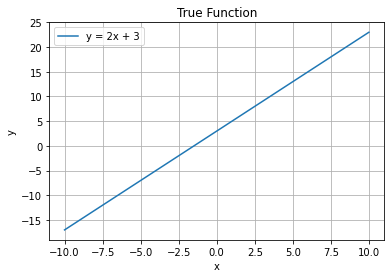

In [9]:
plot_true_function()

Now lets create 200 sample datasets for randomly sampled 100 x from {-100, -99, ..., +99, +100}

In [64]:
# Set a seed for reproducibility
samples = generate_data(noise_std_dev=20)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1630.16it/s]


Visualizing one sample dataset with the true functional values ...

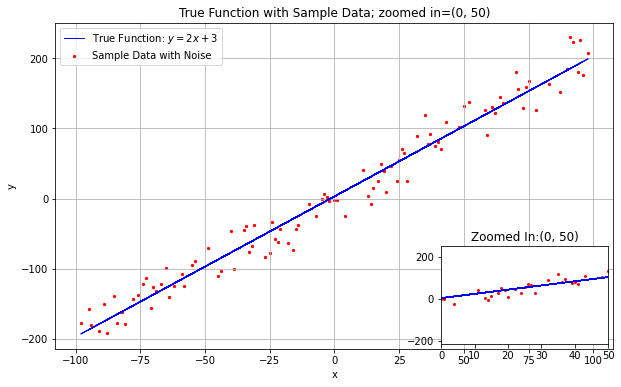

In [86]:
plot_true_function_with_data(samples[10], zoom_in=(0, 50))

# Modelling

## Linear Regression

In [87]:
samples[10][0:10,:]

array([[  -5.        ,   -0.18799962],
       [ -85.        , -138.29636902],
       [ -70.        , -125.71194024],
       [  58.        ,  126.11101259],
       [  28.        ,   25.3042921 ],
       [  15.        ,   14.32555495],
       [ -31.        ,  -38.06159745],
       [  71.        ,  156.39900611],
       [  75.        ,  167.42932548],
       [ -55.        ,  -94.29206136]])